# Clustering Crypto

In [74]:
# Initial imports
import hvplot.pandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# optional imports and environment variable setting
# these are necessary when running in a Google Colab notebook to ensure hvplots display 
import holoviews as hv
%env HV_DOC_HTML=true

env: HV_DOC_HTML=true


## Deliverable 1: Preprocessing the Data for PCA

In [75]:
# Load the crypto_data.csv dataset.
file_path = 'crypto_data.csv'
crypto_df = pd.read_csv(file_path, index_col='Unnamed: 0')

In [76]:
# Keep only the cryptocurrencies that are being traded.
# Keep all the cryptocurrencies that have a working algorithm. # [It's unclear what this means -- there are no NaN values in the 'Algorithm' column; as well, we remove NaNs later on, so not going to take action on 'Algorithm']
# Remove the 'IsTrading' column. 
crypto_df = crypto_df.loc[crypto_df['IsTrading']==True] 
crypto_df.drop('IsTrading', axis=1, inplace=True)
crypto_df.sample(10)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
XVE,The Vegan Initiative,PoS,PoS,NaN,50000000
TODAY,TodayCoin,Scrypt,PoW,NaN,39200000
FLT,FlutterCoin,Scrypt,PoS/PoW/PoT,4.618299e+08,0
XMCC,Monoeci,X11,PoW/PoS,1.256926e+07,9507271
RNC,ReturnCoin,X11,PoS,NaN,250000000
HPC,HappyCoin,X11,PoW/PoS,2.152132e+07,100000000
BBK,BitBlocks,Scrypt,PoW/PoS,0.000000e+00,500000000
SBC,StableCoin,Scrypt,PoW,2.421518e+07,250000000
NETC,NetworkCoin,X13,PoW/PoS,NaN,400000
SXC,SexCoin,Scrypt,PoW,1.289410e+08,250000000


In [77]:
# Remove rows that have at least 1 null value.
crypto_df.dropna(inplace=True)

In [78]:
# Keep the rows where coins are mined.
crypto_df = crypto_df.loc[crypto_df['TotalCoinsMined'] > 0]

In [79]:
# Create a new DataFrame that holds only the cryptocurrencies names.
currency_name_df = pd.DataFrame(crypto_df['CoinName'])

In [80]:
# Drop the 'CoinName' column since it's not going to be used on the clustering algorithm.
crypto_df.drop('CoinName', axis=1, inplace=True)

In [81]:
# Use get_dummies() to create variables for text features.
X = pd.get_dummies(crypto_df, columns=['Algorithm', 'ProofType'])
X.shape

(532, 98)

In [82]:
# Standardize the data with StandardScaler().
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Deliverable 2: Reducing Data Dimensions Using PCA

In [83]:
# Using PCA to reduce dimension to three principal components.
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

print(f'Explained variance ratio:\n{pca.explained_variance_ratio_}')

Explained variance ratio:
[0.02792924 0.02139289 0.02047026]


In [84]:
# Create a DataFrame with the three principal components.
pca_df = pd.DataFrame(
    X_pca, 
    columns=['principal_component_1', 'principal_component_2', 'principal_component_3'],
    index=crypto_df.index
    )
pca_df.head()

,principal_component_1,principal_component_2,principal_component_3
42,-0.322633,1.100463,-0.383230
404,-0.305985,1.100549,-0.383583
1337,2.302471,1.662370,-0.507708
BTC,-0.143688,-1.364192,0.139990
ETH,-0.157903,-2.050860,0.232300


## Deliverable 3: Clustering Crytocurrencies Using K-Means

### Finding the Best Value for `k` Using the Elbow Curve

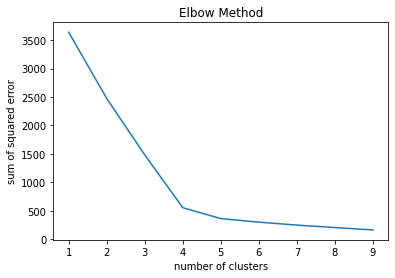

In [86]:
# Create an elbow curve to find the best value for K.
sse = {}
K_range = range(1,10)
for k in K_range:
    kmeans_model = KMeans(n_clusters=k).fit(X_pca)
    sse[k] = kmeans_model.inertia_
    
# plot the results
fig, ax = plt.subplots()
ax.plot(list(sse.keys()), list(sse.values()))
ax.set_xlabel('number of clusters')
ax.set_ylabel('sum of squared error')
ax.set_title('Elbow Method')
plt.show()

Running K-Means with `k=4`

In [87]:
# Initialize the K-Means model. Fit the model.
model = KMeans(n_clusters=4, random_state=420).fit(X_pca)

# Predict clusters
predictions = model.fit_predict(X_pca)

In [88]:
# Create a new DataFrame including predicted clusters and cryptocurrencies features.
# Concatentate the crypto_df and pca_df DataFrames on the same columns.
clustered_df = pd.concat([crypto_df, pca_df], axis=1, join='inner')

#  Add a new column, 'CoinName' to the clustered_df DataFrame that holds the names of the cryptocurrencies. 
clustered_df['CoinName'] = currency_name_df

#  Add a new column, 'Class' to the clustered_df DataFrame that holds the predictions.
clustered_df['class'] = predictions

# Print the shape of the clustered_df
print(clustered_df.shape)
clustered_df.head(10)

(532, 9)


,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,principal_component_1,principal_component_2,principal_component_3,CoinName,class
42,Scrypt,PoW/PoS,4.199995e+01,42,-0.322633,1.100463,-0.383230,42 Coin,0
404,Scrypt,PoW/PoS,1.055185e+09,532000000,-0.305985,1.100549,-0.383583,404Coin,0
1337,X13,PoW/PoS,2.927942e+10,314159265359,2.302471,1.662370,-0.507708,EliteCoin,0
BTC,SHA-256,PoW,1.792718e+07,21000000,-0.143688,-1.364192,0.139990,Bitcoin,1
ETH,Ethash,PoW,1.076842e+08,0,-0.157903,-2.050860,0.232300,Ethereum,1
LTC,Scrypt,PoW,6.303924e+07,84000000,-0.154988,-1.078972,0.006320,Litecoin,1
DASH,X11,PoW/PoS,9.031294e+06,22000000,-0.411913,1.182795,-0.410555,Dash,0
XMR,CryptoNight-V7,PoW,1.720114e+07,0,-0.154000,-2.283091,0.347108,Monero,1
ETC,Ethash,PoW,1.133597e+08,210000000,-0.156347,-2.050966,0.232280,Ethereum Classic,1
ZEC,Equihash,PoW,7.383056e+06,21000000,-0.138290,-1.984705,0.266285,ZCash,1


## Deliverable 4: Visualizing Cryptocurrencies Results

### 3D-Scatter with Clusters

In [89]:
# Creating a 3D-Scatter with the PCA data and the clusters
fig = px.scatter_3d(
    clustered_df,
    x='principal_component_3',
    y='principal_component_2',
    z='principal_component_1',
    color='class',
    symbol='class',
    hover_name='CoinName',
    hover_data=['Algorithm'],
    width=1000
)

fig.update_layout(legend=dict(x=0, y=1))
fig.show()

In [90]:
hv.extension('bokeh')
# Create a table with tradable cryptocurrencies.
tradable_crypto = clustered_df.hvplot.table(
    columns=['CoinName', 'Algorithm', 'ProofType', 'TotalCoinSupply', 'TotalCoinsMined', 'class'],
    sortable=True,
    selectable=True
)
display(tradable_crypto)

Output hidden; open in https://colab.research.google.com to view.

In [91]:
# Print the total number of tradable cryptocurrencies.
print(f'Total number of tradable cryptocurrencies: {len(clustered_df.index)}')

Total number of tradable cryptocurrencies: 532


In [92]:
# Scaling data to create the scatter plot with tradable cryptocurrencies.
minmax_scaler = MinMaxScaler()
cluster_data_scaled = minmax_scaler.fit_transform(clustered_df[['TotalCoinSupply', 'TotalCoinsMined']])

In [93]:
# Create a new DataFrame that has the scaled data with the clustered_df DataFrame index.
plot_df = pd.DataFrame(
    cluster_data_scaled,
    columns=['TotalCoinSupply_scaled', 'TotalCoinsMined_scaled'],
    index=clustered_df.index
    )

# Add the 'CoinName' column from the clustered_df DataFrame to the new DataFrame. Add the 'Class' column from the clustered_df DataFrame to the new DataFrame. 
plot_df['CoinName'] = clustered_df['CoinName']
plot_df['class'] = clustered_df['class']

plot_df.head(10)

,TotalCoinSupply_scaled,TotalCoinsMined_scaled,CoinName,class
42,4.200000e-11,0.000000,42 Coin,0
404,5.320000e-04,0.001066,404Coin,0
1337,3.141593e-01,0.029576,EliteCoin,0
BTC,2.100000e-05,0.000018,Bitcoin,1
ETH,0.000000e+00,0.000109,Ethereum,1
LTC,8.400000e-05,0.000064,Litecoin,1
DASH,2.200000e-05,0.000009,Dash,0
XMR,0.000000e+00,0.000017,Monero,1
ETC,2.100000e-04,0.000115,Ethereum Classic,1
ZEC,2.100000e-05,0.000007,ZCash,1


In [94]:
hv.extension('bokeh')
# Create a hvplot.scatter plot using x='TotalCoinsMined' and y='TotalCoinSupply'.
cluster_plot = plot_df.hvplot.scatter(
    x='TotalCoinsMined_scaled',
    y='TotalCoinSupply_scaled',
    by='class',
    hover_cols=['CoinName']
)
display(cluster_plot)

Output hidden; open in https://colab.research.google.com to view.